In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from efficient_kan.src.efficient_kan import KAN
#from faster_kan.fastkan.fastkan import FastKAN
#from kan import *
from functions import ( set_seed, calculate_gaussian_center_sigma, plot_gaussian, 
                       get_gaussian_params, get_points_after_threshold, calculate_slope_y_intercept)
from functions_KAN import  count_parameters, train_loop_T_Ref
from Models import train_loop_MLP, MLP_Torch

In [2]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
# Load data 
data = np.load('/home/josea/pulsos_Na22_filt_norm_practica_polyfit.npz')['data']
t0_dec0 = np.load('/home/josea/t0_dec0.npz', allow_pickle = True)['data']
t0_dec1 = np.load('/home/josea/t0_dec1.npz', allow_pickle = True)['data']

t0_dec0 = np.array(t0_dec0, dtype = np.float32)
t0_dec1 = np.array(t0_dec1, dtype = np.float32)

# -------------------------------------------------------------------------
#----------------------- IMPORTANT DEFINITIONS ----------------------------
# -------------------------------------------------------------------------

set_seed(42)            # Fix seeds
nbins = 91              # Num bins for all histograms
epochs = 500
lr = 1e-3                   
threshold = 0.05        # Threshold for trigger
num_points = 4          # Number of points after trigger
time_step = 0.2         # Signal time step

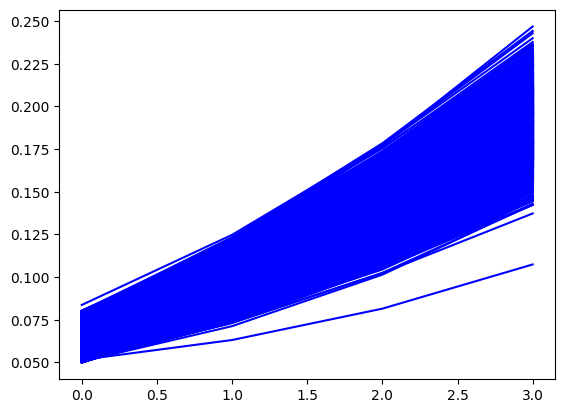

In [4]:
waveform_data = data[18000:,:,:]
cut_data = get_points_after_threshold(waveform_data, fraction = threshold, num_points = num_points)
for i in range(cut_data.shape[0]):
    plt.plot(cut_data[i,:,0], 'b-')
plt.show()

In [5]:
# Get timestamps
timestamps_dec0_list = []
timestamps_dec1_list = []

for i in range(waveform_data.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(waveform_data[i,:,0], time_step, threshold = threshold)
  timestamp_dec1 = calculate_slope_y_intercept(waveform_data[i,:,1], time_step, threshold = threshold)
  timestamps_dec0_list.append(timestamp_dec0)
  timestamps_dec1_list.append(timestamp_dec1)

timestamp_dec0 = np.array(timestamps_dec0_list)
timestamp_dec1 = np.array(timestamps_dec1_list)

In [6]:
data_dec0 = np.concatenate((timestamp_dec0[:, np.newaxis], cut_data[:,:,0]), axis = 1)
data_dec1 = np.concatenate((timestamp_dec1[:, np.newaxis], cut_data[:,:,1]), axis = 1)
data = np.stack((data_dec0, data_dec1), axis = -1)

In [7]:
# -------------------------------------------------------------------------
#----------------------- TRAIN/TEST SPLIT ---------------------------------
# -------------------------------------------------------------------------
num_train = 2000

train_data = data[:num_train,:,:]
train_labels_dec0 = t0_dec0[:num_train] 
train_labels_dec1 = t0_dec1[:num_train]

validation_data = data[num_train:num_train + 1,:,:] 
val_labels_dec0 = t0_dec0[num_train:num_train + 1]  
val_labels_dec1 = t0_dec1[num_train:num_train + 1] 

test_data = data[num_train:,:,:]
test_labels_dec0 = t0_dec0[num_train:] 
test_labels_dec1 = t0_dec1[num_train:]

print('Número de casos de entrenamiento: ', train_data.shape[0])
print('Número de casos de test: ', test_data.shape[0])

Número de casos de entrenamiento:  2000
Número de casos de test:  1075


In [8]:
# Create Datasets/Dataloaders
train_dataset_dec0 = torch.utils.data.TensorDataset(torch.from_numpy(train_data[:,:,0]).float(), torch.from_numpy(np.expand_dims(train_labels_dec0, axis = -1)).float())
train_dataset_dec1 = torch.utils.data.TensorDataset(torch.from_numpy(train_data[:,:,1]).float(), torch.from_numpy(np.expand_dims(train_labels_dec1, axis = -1)).float())

val_dataset_dec0 = torch.utils.data.TensorDataset(torch.from_numpy(validation_data[:,:,0]).float(), torch.from_numpy(np.expand_dims(val_labels_dec0, axis = -1)).float())
val_dataset_dec1 = torch.utils.data.TensorDataset(torch.from_numpy(validation_data[:,:,1]).float(), torch.from_numpy(np.expand_dims(val_labels_dec1, axis = -1)).float())

train_loader_dec0 = torch.utils.data.DataLoader(train_dataset_dec0, batch_size = 32, shuffle = True)
train_loader_dec1 = torch.utils.data.DataLoader(train_dataset_dec1, batch_size = 32, shuffle = True)

val_loader_dec0 = torch.utils.data.DataLoader(val_dataset_dec0, batch_size = 32, shuffle = True)
val_loader_dec1 = torch.utils.data.DataLoader(val_dataset_dec1, batch_size = 32, shuffle = True)

In [9]:
# -------------------------------------------------------------------------
# ------------------------------ MODEL ------------------------------------
# -------------------------------------------------------------------------

architecture = [num_points + 1, 3, 1, 1]    

model_dec0 = KAN(architecture)
model_dec1 = KAN(architecture)

print(f"Total number of parameters: {count_parameters(model_dec0)}")

optimizer_dec0 = torch.optim.AdamW(model_dec0.parameters(), lr = lr) 
optimizer_dec1 = torch.optim.AdamW(model_dec1.parameters(), lr = lr)  

# Execute train loop
loss_dec0, val_loss_dec0, test_dec0 = train_loop_T_Ref(model_dec0, optimizer_dec0, train_loader_dec0, val_loader_dec0, torch.tensor(test_data[:,:,0]).float(), EPOCHS = epochs, save = False) 
loss_dec1, val_loss_dec1, test_dec1 = train_loop_T_Ref(model_dec1, optimizer_dec1, train_loader_dec1, val_loader_dec1, torch.tensor(test_data[:,:,1]).float(), EPOCHS = epochs, save = False)

Total number of parameters: 347
EPOCH 1:
LOSS train 6.505252804074969
LOSS val 2.8264760971069336


/home/josea/.local/lib/python3.11/site-packages/kan/KAN.py:327: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))


EPOCH 2:
LOSS train 1.6093380735034035
LOSS val 0.5447245240211487
EPOCH 3:
LOSS train 0.3631866613314265
LOSS val 0.06767499446868896
EPOCH 4:
LOSS train 0.0682658101062453
LOSS val 0.003613825188949704
EPOCH 5:
LOSS train 0.03523816390051728
LOSS val 0.003644410753622651
EPOCH 6:
LOSS train 0.03340543765160772
LOSS val 0.003484258893877268
EPOCH 7:
LOSS train 0.031670117070750584
LOSS val 0.0017693961272016168
EPOCH 8:
LOSS train 0.029935741309253944
LOSS val 0.0027451845817267895
EPOCH 9:
LOSS train 0.02833523398767861
LOSS val 0.003079300746321678
EPOCH 10:
LOSS train 0.026617003102151173
LOSS val 0.002807310549542308
EPOCH 11:
LOSS train 0.024925301797569743
LOSS val 0.002603572327643633
EPOCH 12:
LOSS train 0.02343442291021347
LOSS val 0.0014934843638911843
EPOCH 13:
LOSS train 0.02191759839594837
LOSS val 0.0024520843289792538
EPOCH 14:
LOSS train 0.020379296637007167
LOSS val 0.0008665443165227771
EPOCH 15:
LOSS train 0.019080366392339034
LOSS val 0.00045526132453233004
EPOCH 1

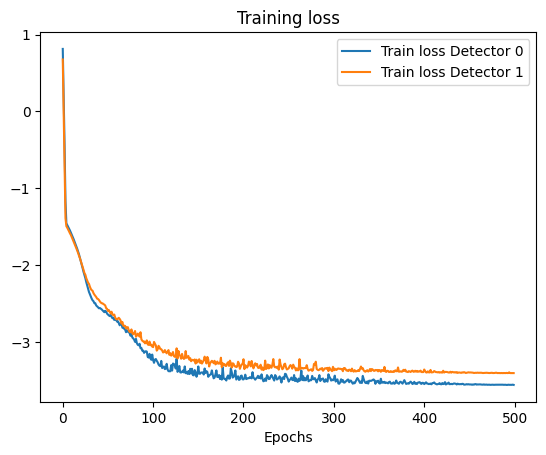

In [10]:
plt.plot(np.log10(loss_dec0.astype('float32')), label = 'Train loss Detector 0')
plt.plot(np.log10(loss_dec1.astype('float32')), label = 'Train loss Detector 1')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

Detector 0: CENTROID(ns) = -0.000 +/- 0.000  FWHM(ns) = 0.037 +/- 0.000
Detector 1: CENTROID(ns) = -0.000 +/- 0.000  FWHM(ns) = 0.044 +/- 0.000
TOF Pred: CENTROID(ns) = -0.001 +/- 0.001  FWHM(ns) = 0.214 +/- 0.001
TOF Ground: CENTROID(ns) = 0.000 +/- 0.001  FWHM(ns) = 0.223 +/- 0.001


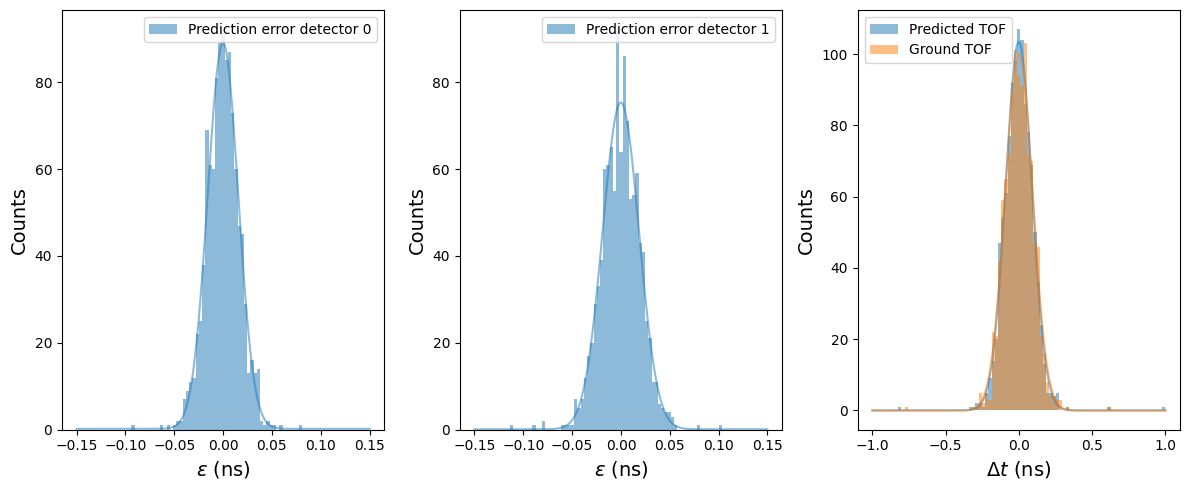

In [11]:
# Calculate prediction errors and TOFs
pred_err_dec0 = test_dec0[-1,:] - test_labels_dec0
pred_err_dec1 = test_dec1[-1,:] - test_labels_dec1
TOF_pred = test_dec0[-1,:] - test_dec1[-1,:]
TOF_ground = test_labels_dec0 - test_labels_dec1

centroid_dec0, sigmaN_dec0 = calculate_gaussian_center_sigma(pred_err_dec0[np.newaxis,:], np.zeros((pred_err_dec0[np.newaxis,:].shape[0])), nbins = nbins) 
centroid_dec1, sigmaN_dec1 = calculate_gaussian_center_sigma(pred_err_dec1[np.newaxis,:], np.zeros((pred_err_dec1[np.newaxis,:].shape[0])), nbins = nbins) 
centroid_pred, sigmaN_pred = calculate_gaussian_center_sigma(TOF_pred[np.newaxis,:], np.zeros((TOF_pred[np.newaxis,:].shape[0])), nbins = nbins) 
centroid_ground, sigmaN_ground = calculate_gaussian_center_sigma(TOF_ground[np.newaxis,:], np.zeros((TOF_ground[np.newaxis,:].shape[0])), nbins = nbins) 

# Histogram and gaussian fit 
plt.figure(figsize = (12,5))

plt.subplot(131)
plot_gaussian(pred_err_dec0, centroid_dec0, range = 0.15, nbins = nbins, label = 'Prediction error detector 0')
plt.xlabel('$\epsilon$ (ns)', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
plt.legend()

plt.subplot(132)
plot_gaussian(pred_err_dec1, centroid_dec1, range = 0.15, nbins = nbins, label = 'Prediction error detector 1')
plt.xlabel('$\epsilon$ (ns)', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
plt.legend()

plt.subplot(133)
plot_gaussian(TOF_pred, centroid_pred, range = 1, nbins = nbins, label = 'Predicted TOF')
plot_gaussian(TOF_ground, centroid_ground, range = 1, nbins = nbins, label = 'Ground TOF')
plt.xlabel('$\Delta t$ (ns)', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
plt.legend()
plt.tight_layout()


# Print params
params_dec0, errors_dec0 = get_gaussian_params(pred_err_dec0, centroid_dec0, range = 0.15, nbins = nbins)
params_dec1, errors_dec1 = get_gaussian_params(pred_err_dec1, centroid_dec1, range = 0.15, nbins = nbins)
params_pred, errors_pred = get_gaussian_params(TOF_pred, centroid_pred, range = 1, nbins = nbins)
params_ground, errors_ground = get_gaussian_params(TOF_ground, centroid_ground, range = 1, nbins = nbins)


print("Detector 0: CENTROID(ns) = %.3f +/- %.3f  FWHM(ns) = %.3f +/- %.3f" % (params_dec0[2], errors_dec0[2], params_dec0[3], errors_dec0[3]))
print("Detector 1: CENTROID(ns) = %.3f +/- %.3f  FWHM(ns) = %.3f +/- %.3f" % (params_dec1[2], errors_dec1[2], params_dec1[3], errors_dec1[3]))
print("TOF Pred: CENTROID(ns) = %.3f +/- %.3f  FWHM(ns) = %.3f +/- %.3f" % (params_pred[2], errors_pred[2], params_pred[3], errors_pred[3]))
print("TOF Ground: CENTROID(ns) = %.3f +/- %.3f  FWHM(ns) = %.3f +/- %.3f" % (params_ground[2], errors_ground[2], params_ground[3], errors_ground[3]))